# Fraud detection

## Load data

In [1]:
# import pandas as pd
# train_identity = pd.read_csv('../data/train_identity.csv')
# train_transaction = pd.read_csv('../data/train_transaction.csv')

# df_fraud = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
# df_fraud.to_csv('../data/data_fraud.csv', index=False)

In [2]:
import pandas as pd

df_fraud = pd.read_csv('../data/data_fraud.csv')

/tmp/ipykernel_99798/1690452675.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## EDA

In [3]:
df_fraud.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_fraud.shape

(590540, 434)

In [5]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [6]:
df_fraud.isnull().sum().sum()

115523073

We have a lot of missing values

In [7]:
missing_data_count = df_fraud.isnull().sum()
missing_data_percentage = round((missing_data_count / len(df_fraud)) * 100, 1)

missing_data_stats = pd.DataFrame({
    'Missing data (count)': missing_data_count,
    'Missing data (%)': missing_data_percentage
})

missing_data_stats.sort_values(by='Missing data (%)', ascending=False).head(10)

,Missing data (count),Missing data (%)
id_24,585793,99.2
id_25,585408,99.1
id_26,585377,99.1
id_21,585381,99.1
id_22,585371,99.1
id_23,585371,99.1
id_08,585385,99.1
id_07,585385,99.1
id_27,585371,99.1
dist2,552913,93.6


## Encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder

object_df = df_fraud.select_dtypes(include=['object'])

encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(object_df)

categories = encoder.categories_

encoded_columns = []
for i, col in enumerate(object_df.columns):
    encoded_columns.extend([f"{col}_{category}" for category in categories[i][1:]])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoded_columns)

df_fraud = df_fraud.drop(columns=object_df.columns)
df_fraud = pd.concat([df_fraud, encoded_df], axis=1)

In [9]:
df_fraud.shape

(590540, 2834)

In [10]:
correlation = df_fraud.drop('isFraud', axis=1).corrwith(df_fraud['isFraud']).apply(abs).sort_values(ascending=False)
correlation.head()

V257    0.383060
V246    0.366878
V244    0.364129
V242    0.360590
V201    0.328005
dtype: float64

In [11]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()
thresholds = np.arange(0, correlation[0], 0.005)
nb_col2drop = []

for threshold in thresholds:
    columns_to_drop = correlation[correlation < threshold].index
    nb_col2drop.append(len(columns_to_drop))

fig.add_trace(go.Scatter(x=thresholds, y=nb_col2drop, mode='lines+markers'))
fig.update_layout(title='Number of columns to drop depending on the correlation threshold',
                  xaxis_title='Threshold',
                  yaxis_title='Number of columns to drop')


/tmp/ipykernel_99798/376363404.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



But before that, let's see the correlation between each variable and the output to be sure we are not eliminating a relevant variable.

In [12]:
threshold = 0.05
columns_to_drop = correlation[correlation < threshold].index

In [13]:
df_fraud_filtered = df_fraud.drop(columns=columns_to_drop)

print(f'Columns dropped: {columns_to_drop}\n')
print(f'Elimated columns: {len(columns_to_drop)}')
print(f'Missing values eliminated: {df_fraud.isnull().sum().sum() - df_fraud_filtered.isnull().sum().sum()}')

Columns dropped: Index(['V254', 'id_31_mobile safari generic', 'V117', 'V61', 'id_02', 'V3',
       'DeviceInfo_LG-D320 Build/KOT49I.V10a', 'DeviceInfo_Windows', 'V315',
       'V119',
       ...
       'DeviceInfo_SM-A310M Build/LMY47X', 'DeviceInfo_VS995 Build/NRD90M',
       'V319', 'id_33_3000x2000', 'R_emaildomain_aol.com',
       'P_emaildomain_embarqmail.com', 'V136', 'id_31_chrome 51.0',
       'R_emaildomain_yahoo.es', 'P_emaildomain_yahoo.fr'],
      dtype='object', length=2618)

Elimated columns: 2618
Missing values eliminated: 55304710


In [14]:
df_fraud_filtered.head()

,isFraud,card3,D1,D2,D4,D5,D6,D7,D8,D10,...,id_35_nan,id_36_nan,id_37_T,id_37_nan,id_38_nan,DeviceType_mobile,DeviceType_nan,DeviceInfo_SM-A300H Build/LRX22G,DeviceInfo_hi6210sft Build/MRA58K,DeviceInfo_nan
0,0,150.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0,150.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0,150.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0,150.0,112.0,112.0,94.0,0.0,NaN,NaN,NaN,84.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0,150.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
df_fraud_filtered.to_csv('../data/data_fraud_filtered.csv', index=False)

## Preprocessing

### Load encoded data

In [1]:
import pandas as pd

df_fraud_filtered = pd.read_csv('../data/data_fraud_filtered.csv')

/tmp/ipykernel_102066/703400563.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Imputation of data

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

imputer = IterativeImputer(n_nearest_features=10, random_state=42)
imputer.fit(df_fraud_filtered)
df_fraud_imputed = imputer.transform(df_fraud_filtered)
df_fraud_imputed = pd.DataFrame(df_fraud_imputed, columns=df_fraud_filtered.columns)

In [3]:
df_fraud_imputed.to_csv('../data/data_fraud_imputed.csv', index=False)

### Delete multicolinearity with VIF on a sample

In [5]:
import pandas as pd

df_fraud_imputed = pd.read_csv('../data/data_fraud_imputed.csv')

In [6]:
size_sample = 5000
df_sampled = df_fraud_imputed.sample(n=size_sample, random_state=42)

In [8]:
from utils import delete_multicollinearity

df_fraud_preprocessed = delete_multicollinearity(df_sampled, 'isFraud', 10)

Dropped column M9_nan with VIF: inf (29s)
Dropped column M8_nan with VIF: inf (30s)
Dropped column M2_nan with VIF: inf (35s)
Dropped column M1_nan with VIF: inf (32s)
Dropped column id_35_nan with VIF: inf (25s)
Dropped column id_38_nan with VIF: inf (27s)
Dropped column id_28_nan with VIF: inf (24s)
Dropped column id_37_nan with VIF: inf (27s)
Dropped column id_36_nan with VIF: inf (28s)
Dropped column id_29_nan with VIF: inf (29s)
Dropped column DeviceType_nan with VIF: 5483.9 (36s)
Dropped column D7 with VIF: 3236.4 (31s)
Dropped column id_26 with VIF: 2957.3 (32s)
Dropped column id_22 with VIF: 2880.8 (24s)
Dropped column V249 with VIF: 2812.6 (24s)
Dropped column id_32 with VIF: 2422.9 (26s)
Dropped column V111 with VIF: 2049.6 (24s)
Dropped column V197 with VIF: 2009.0 (25s)
Dropped column V190 with VIF: 1682.7 (21s)
Dropped column M1_T with VIF: 1633.6 (28s)
Dropped column V108 with VIF: 1526.7 (26s)
Dropped column id_15_nan with VIF: 1463.0 (23s)
Dropped column V148 with VIF: 

In [13]:
columns_to_keep = list(df_fraud_preprocessed.columns) + ['isFraud']
df_fraud_final = df_fraud_imputed[columns_to_keep]

In [14]:
df_fraud_final.shape

(590540, 59)

In [18]:
correlation = df_fraud_final.drop('isFraud', axis=1).corrwith(df_fraud_final['isFraud']).apply(abs).sort_values(ascending=False)
correlation.head()

V200    0.219812
V258    0.201618
V73     0.172292
V146    0.171017
V34     0.168216
dtype: float64

In [19]:
df_fraud_final.to_csv('../data/data_fraud_final.csv', index=False)

In [2]:
import pandas as pd

df_fraud_preprocessed = pd.read_csv('../data/data_fraud_final.csv')

/tmp/ipykernel_106155/2919787292.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
df_fraud_preprocessed.columns

Index(['D1', 'D4', 'D5', 'D6', 'D8', 'D10', 'D13', 'D15', 'V12', 'V30', 'V34',
       'V35', 'V40', 'V56', 'V62', 'V64', 'V70', 'V73', 'V75', 'V78', 'V82',
       'V142', 'V144', 'V146', 'V162', 'V165', 'V169', 'V184', 'V185', 'V200',
       'V220', 'V222', 'V229', 'V235', 'V238', 'V258', 'V281', 'V282', 'V283',
       'V303', 'id_01', 'id_04', 'card6_credit', 'R_emaildomain_gmail.com',
       'R_emaildomain_hotmail.com', 'M3_T', 'M3_nan', 'M4_M2', 'M6_T',
       'M6_nan', 'M9_T', 'id_12_NotFound', 'id_31_chrome 64.0 for android',
       'id_31_chrome generic', 'id_37_T', 'DeviceType_mobile',
       'DeviceInfo_SM-A300H Build/LRX22G', 'DeviceInfo_hi6210sft Build/MRA58K',
       'isFraud'],
      dtype='object')

In [6]:
col_eda = ['D1', 'D10', 'V12', 'V34', 'V56', 'V70', 'V142', 'V185', 'V222', 'V303']
data_eda = df_fraud_preprocessed[col_eda]

In [8]:
data_eda.describe()

,D1,D10,V12,V34,V56,V70,V142,V185,V222,V303
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,94.301743,114.352936,0.492291,0.190198,1.150817,0.390706,0.010791,-0.037418,1.270398,0.283142
std,157.524195,172.379537,0.508327,0.368357,0.638586,0.520211,0.124111,0.367969,1.471701,0.623605
min,-115.084395,-151.869924,-0.440740,-0.497503,-0.082415,-0.200048,-1.089099,-3.051093,-0.529198,-0.000261
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.008494,-0.129965,1.000000,0.000000
50%,3.000000,38.000000,0.043055,0.000000,1.000000,0.000000,0.000000,-0.082091,1.096201,0.000000
75%,122.000000,151.000000,1.000000,0.000000,1.000000,1.000000,0.006050,0.000000,1.370180,0.000000
max,640.000000,876.000000,3.000000,13.000000,51.000000,6.000000,9.000000,31.000000,384.000000,20.000000


### Histplot

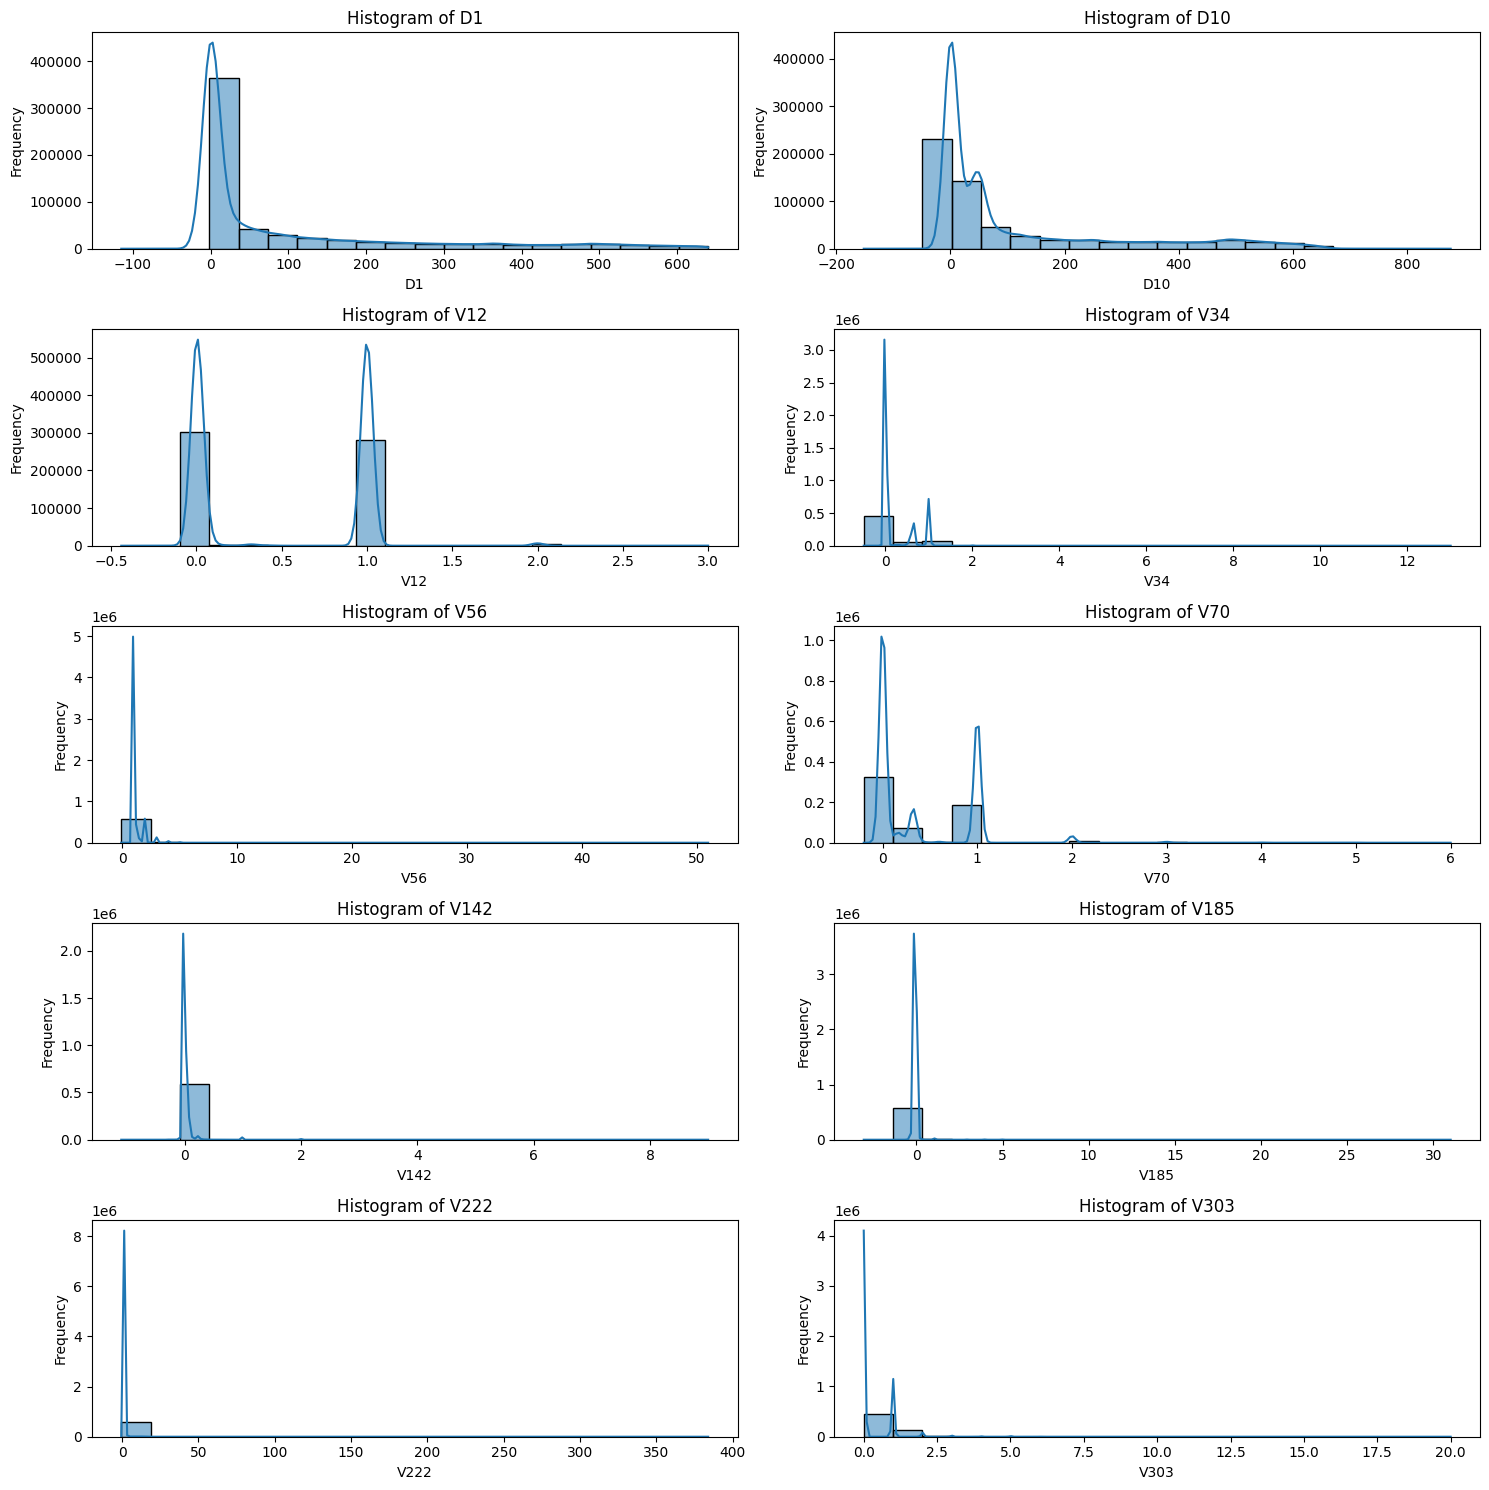

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(data_eda.columns):
    sns.histplot(data=data_eda, x=var, bins=20, kde=True, ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {var}')

plt.tight_layout()
plt.show()


### Boxplot

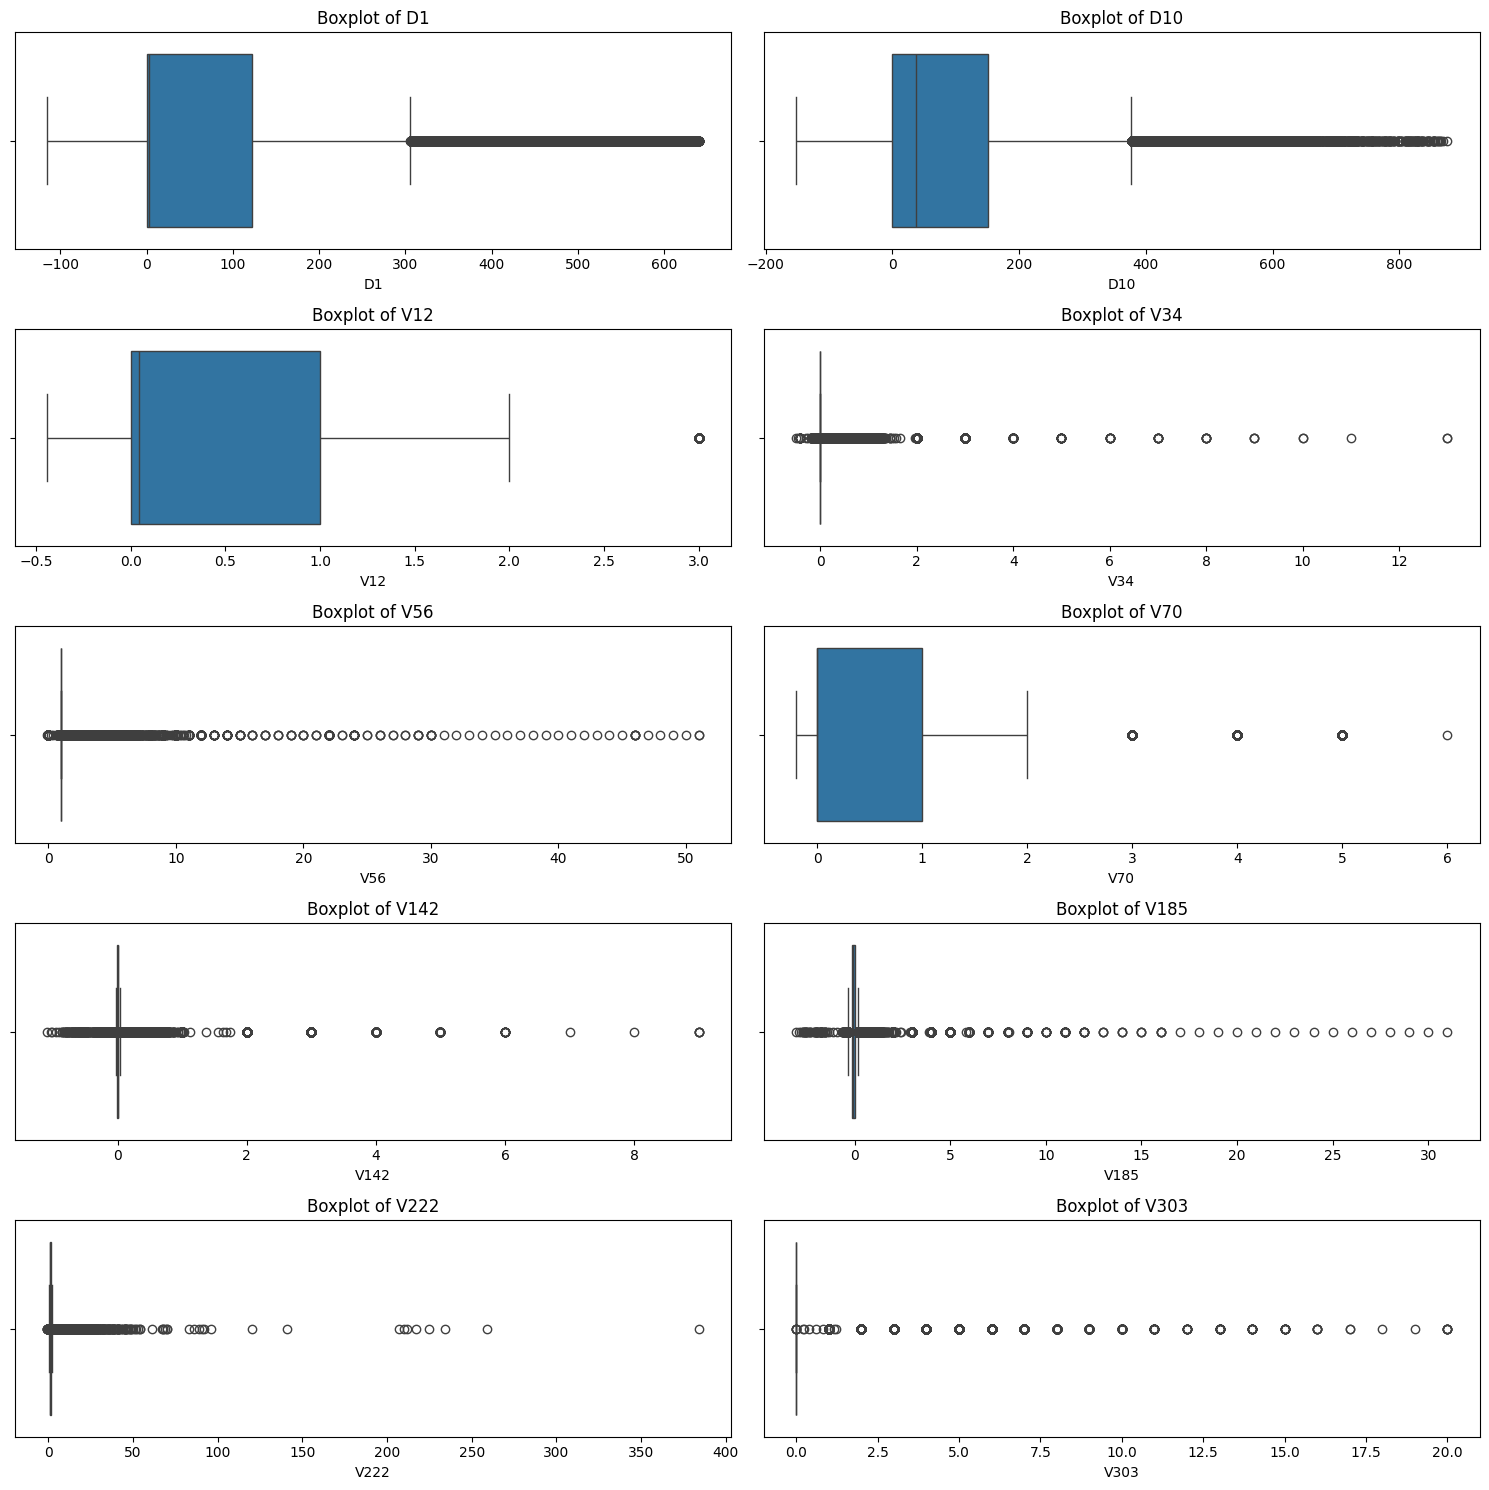

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(data_eda.columns):
    sns.boxplot(x=data_eda[var], ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_title(f'Boxplot of {var}')

plt.tight_layout()
plt.show()